In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Load the dataset
df = pd.read_excel("./dataset.xlsx")

In [2]:
"""EDA"""
print(df.head())
print(df.info())

print("Checking for missing values...")
print(df.isnull().sum())

print("Checking for duplicates:", end=" ")
print(df.duplicated().sum())
print("Summarizing the data:")
print(df.describe())
print("Columns in the dataset:")
print(df.columns.tolist())

                                             img                        title  \
0  /games/boxart/full_6510540AmericaFrontccc.jpg           Grand Theft Auto V   
1  /games/boxart/full_5563178AmericaFrontccc.jpg           Grand Theft Auto V   
2                    /games/boxart/827563ccc.jpg  Grand Theft Auto: Vice City   
3  /games/boxart/full_9218923AmericaFrontccc.jpg           Grand Theft Auto V   
4  /games/boxart/full_4990510AmericaFrontccc.jpg    Call of Duty: Black Ops 3   

  console    genre       publisher       developer  critic_score  total_sales  \
0     PS3   Action  Rockstar Games  Rockstar North           9.4        20.32   
1     PS4   Action  Rockstar Games  Rockstar North           9.7        19.39   
2     PS2   Action  Rockstar Games  Rockstar North           9.6        16.15   
3    X360   Action  Rockstar Games  Rockstar North           NaN        15.86   
4     PS4  Shooter      Activision        Treyarch           8.1        15.09   

   na_sales  jp_sales  pal

In [3]:
# Handling missing values
df = df.drop(columns=['last_update'])

sales_columns = ['total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales']
df[sales_columns] = df[sales_columns].fillna(0)

df_critic = df.dropna(subset=['critic_score'])

df['release_year'] = pd.to_datetime(df['release_date']).dt.year
df['release_month'] = pd.to_datetime(df['release_date']).dt.month

# Keeping only the relevant columns
key_columns = ['title', 'console', 'genre', 'publisher', 'developer', 'critic_score', 'release_date', 'release_year', 'release_month'] + sales_columns

clean_df = df[key_columns]

df = clean_df.head(10000)

In [4]:
# ? Outlier Detection using z_score
# Select numeric columns for outlier detection
numeric_cols = ['total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales', 'critic_score']

# Drop rows with missing critic_score
df_z = df.dropna(subset=['critic_score'])

# Calculate z-scores manually
z_scores = (df_z[numeric_cols] - df_z[numeric_cols].mean()) / df_z[numeric_cols].std()

# Detect outliers
outliers = (np.abs(z_scores) > 3)

# Count and show outliers
print(f"Number of outliers found: {outliers.sum()}")

Number of outliers found: total_sales     52
na_sales        63
jp_sales        64
pal_sales       59
other_sales     64
critic_score    32
dtype: int64


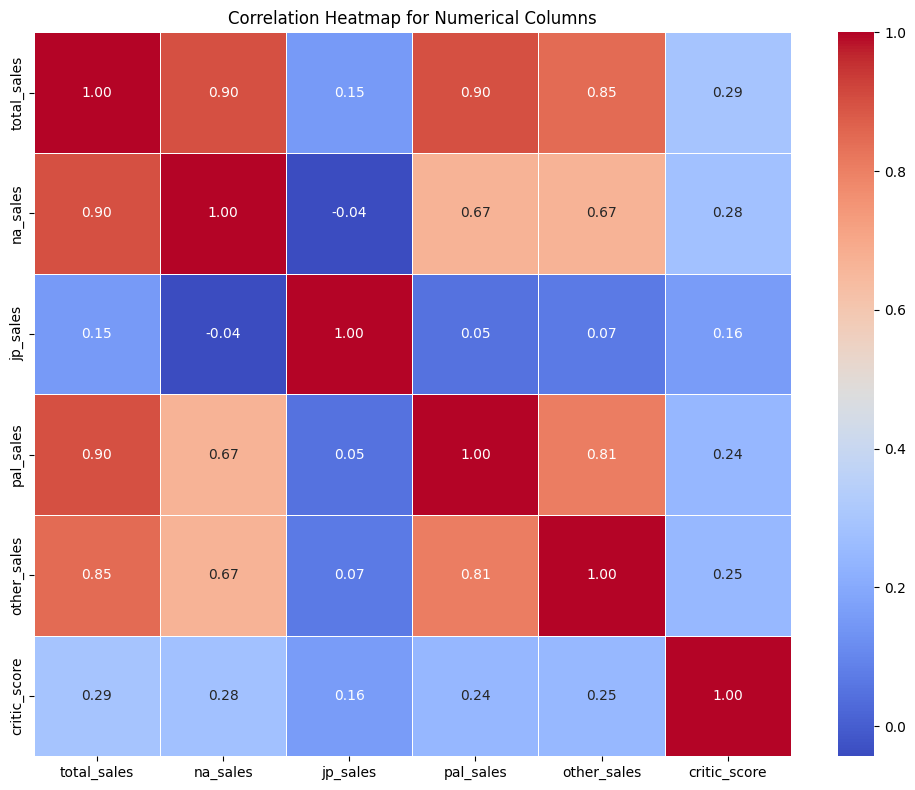

In [5]:
# ? Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_cols].corr()
sb.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap for Numerical Columns")
plt.tight_layout()
plt.show()

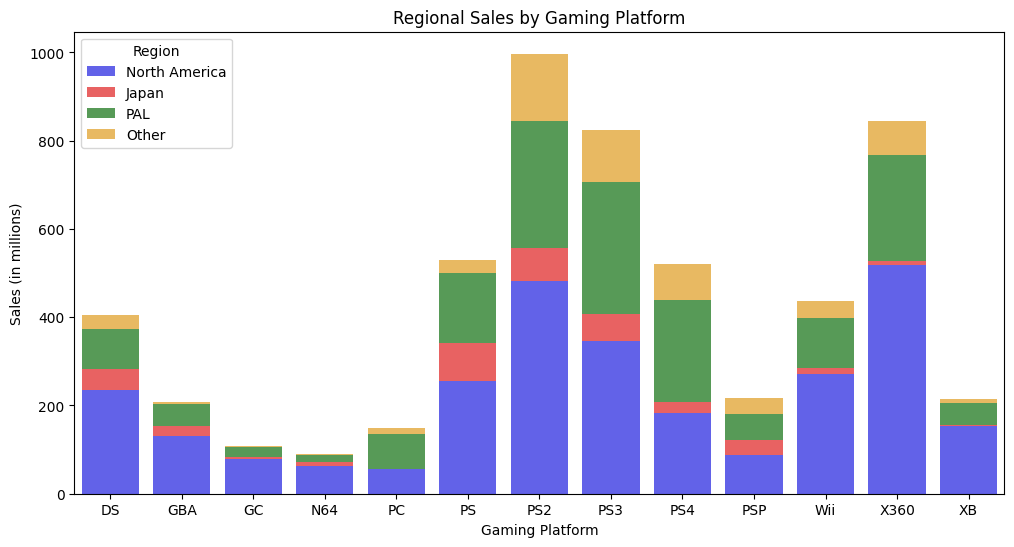

In [6]:
# ! Objective 1. Platform vs Region — Which platform performs better where? by analyzing the sales data by platform and region.

# List of popular consoles
popular_consoles = ["PS", "PS2", "PS3", "PS4", "PS5", "XONE", "X360",
                    "PC", "PSP", "Wii", "DS", "XB", "GBA", "GC", "2600", "N64"]

# Filter the dataset to only keep rows where console is in the popular list
data = df[df['console'].isin(popular_consoles)]

# Group by console and calculate the sum of sales for each region
region_sales = data.groupby('console')[['na_sales', 'jp_sales', 'pal_sales', 'other_sales']].sum()

plt.figure(figsize=(12, 6))

# Create a bar plot for each region
sb.barplot(x=region_sales.index, y=region_sales['na_sales'], label='North America', color='blue', alpha=0.7)
sb.barplot(x=region_sales.index, y=region_sales['jp_sales'], label='Japan', color='red', alpha=0.7, bottom=region_sales['na_sales'])
sb.barplot(x=region_sales.index, y=region_sales['pal_sales'], label='PAL', color='green', alpha=0.7, bottom=region_sales['na_sales'] + region_sales['jp_sales'])
sb.barplot(x=region_sales.index, y=region_sales['other_sales'], label='Other', color='orange', alpha=0.7, bottom=region_sales['na_sales'] + region_sales['jp_sales'] + region_sales['pal_sales'])

plt.title('Regional Sales by Gaming Platform')
plt.xlabel('Gaming Platform')
plt.ylabel('Sales (in millions)')
plt.legend(title='Region')
plt.show()

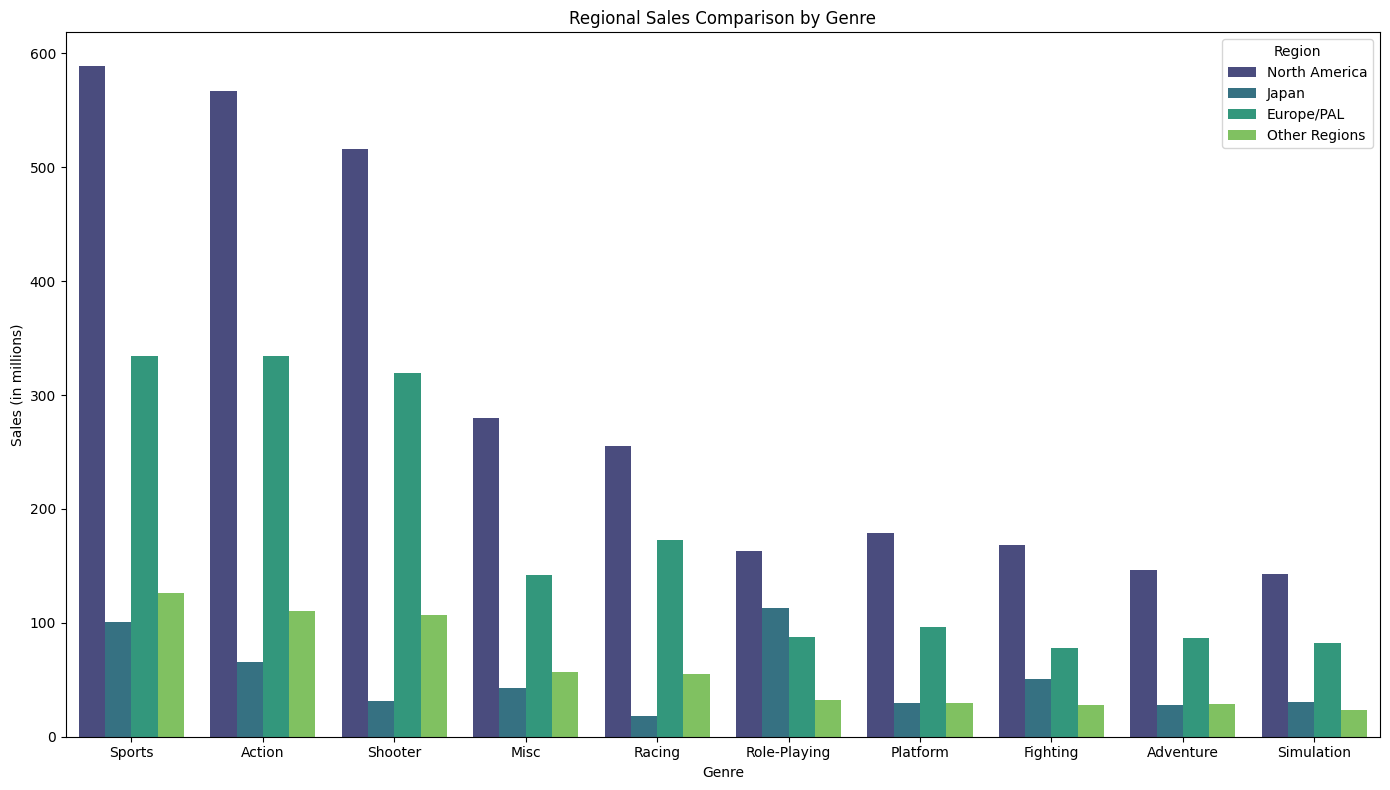

In [7]:
# ! Objective 2: Top Genres — Who loves what genre, and where? by analyzing the sales data by genre and region.

# Popular Genres
popular_genres = ["Action", "Shooter", "Sports", "Role-Playing", "Adventure", "Platform", "Simulation", "Platform", "Racing", "Misc", "Fighting"]

# Group by genre and calculate the sum of sales for each region
data = df[df['genre'].isin(popular_genres)]
genre_sales = data.groupby('genre')[['na_sales', 'jp_sales', 'pal_sales', 'other_sales']].sum()

# Sort the data by total sales (sum of all regions) in descending order
genre_sales['total_sales'] = genre_sales.sum(axis=1)
genre_sales = genre_sales.sort_values(by='total_sales', ascending=False).head(15)  # Top 15 genres

# Grouped bar chart for easier comparison between regions
plt.figure(figsize=(14, 8))
genre_sales = genre_sales.reset_index().melt(
    id_vars=['genre', 'total_sales'],
    value_vars=['na_sales', 'jp_sales', 'pal_sales', 'other_sales'],
    var_name='region', value_name='sales'
)
genre_sales['region'] = genre_sales['region'].map({
    'na_sales': 'North America',
    'jp_sales': 'Japan',
    'pal_sales': 'Europe/PAL',
    'other_sales': 'Other Regions'
})

sb.barplot(x='genre', y='sales', hue='region', data=genre_sales, palette='viridis')
plt.title('Regional Sales Comparison by Genre')
plt.xlabel('Genre')
plt.ylabel('Sales (in millions)')
plt.legend(title='Region')
plt.tight_layout()
plt.show()

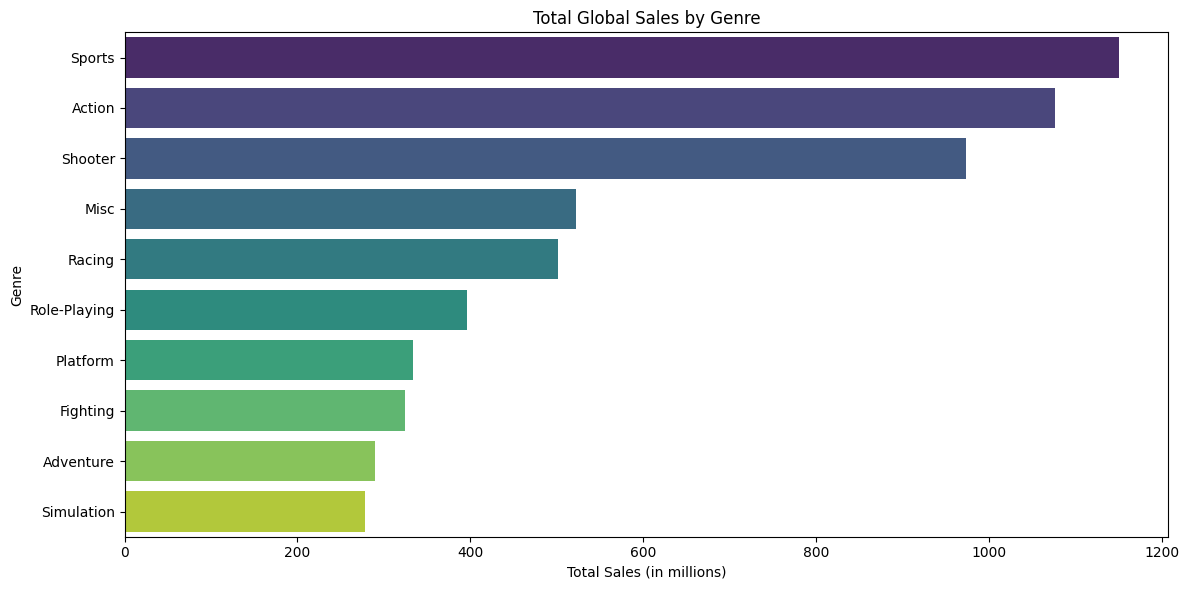

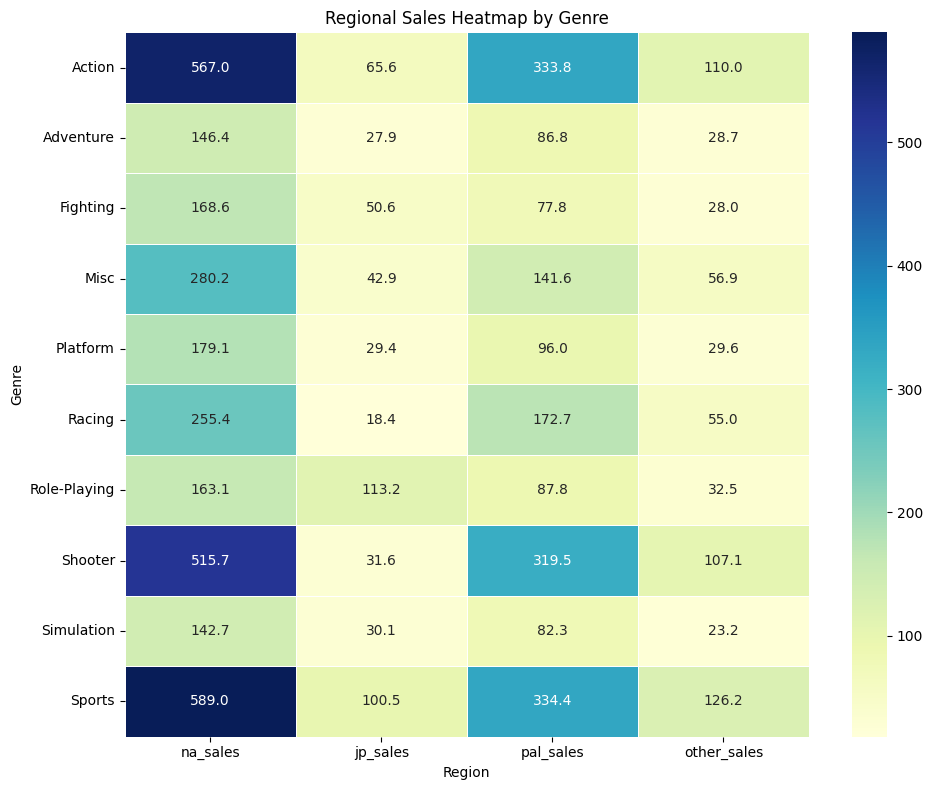

In [8]:
# ! To determine which genres are most appealing to consumers and where by analyzing total and regional sales figures by game genre like Action, Shooter, Sports.

# Total Sales by Genre
data = df[df['genre'].isin(popular_genres)]
total_sales_by_genre = data.groupby("genre")["total_sales"].sum().sort_values(ascending=False)

# Regional Sales by Genre
regional_sales_by_genre = data.groupby("genre")[["na_sales", "jp_sales", "pal_sales", "other_sales"]].sum()

# Plotting Total Sales by Genre
plt.figure(figsize=(12, 6))
sb.barplot(x=total_sales_by_genre.values, y=total_sales_by_genre.index, hue=total_sales_by_genre.index, palette="viridis")
plt.title("Total Global Sales by Genre")
plt.xlabel("Total Sales (in millions)")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

# Plotting Regional Sales by Genre
plt.figure(figsize=(10, 8))
sb.heatmap(regional_sales_by_genre, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5)
plt.title("Regional Sales Heatmap by Genre")
plt.xlabel("Region")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

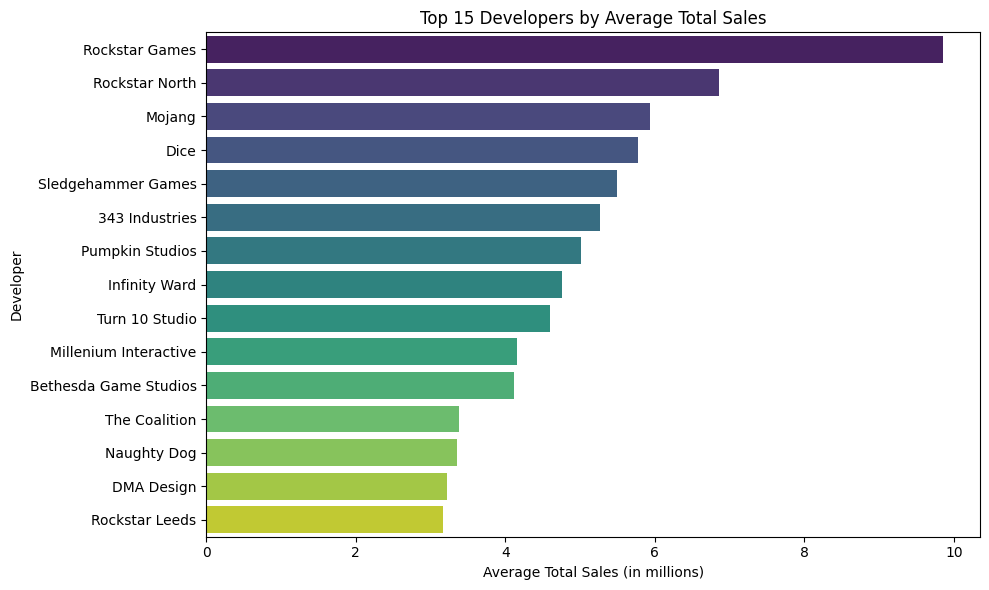

In [9]:
# ! Objective 3: To check how developers affect game sales and ratings

developer_sales = (
    df.groupby("developer")["total_sales"]
    .mean()
    .sort_values(ascending=False)
    .head(15)
)

plt.figure(figsize=(10, 6))
sb.barplot(x=developer_sales.values, y=developer_sales.index, hue=developer_sales.index, palette="viridis")
plt.title("Top 15 Developers by Average Total Sales")
plt.xlabel("Average Total Sales (in millions)")
plt.ylabel("Developer")
plt.tight_layout()
plt.show()

C:\Users\Aditya\AppData\Local\Temp\ipykernel_19164\2406800336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["score_range"] = pd.cut(df["critic_score"], bins=[0, 5, 6, 7, 8, 9, 10], labels=["0-5", "5-6", "6-7", "7-8", "8-9", "9-10"])


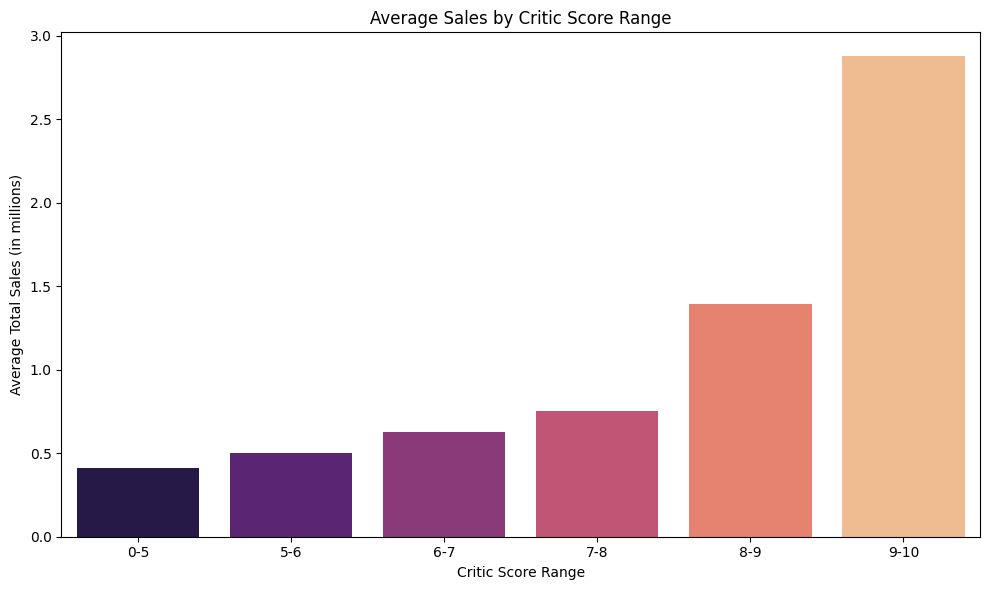

In [10]:
# ! Objective 4: Critic Score vs Sales — Do reviews actually matter?

df["score_range"] = pd.cut(df["critic_score"], bins=[0, 5, 6, 7, 8, 9, 10], labels=["0-5", "5-6", "6-7", "7-8", "8-9", "9-10"])

plt.figure(figsize=(10, 6))
sb.barplot(data=df[df["score_range"].notnull() & df["total_sales"].notnull()],
            x="score_range", y="total_sales", hue="score_range", palette="magma", errorbar=None)
plt.title("Average Sales by Critic Score Range")
plt.xlabel("Critic Score Range")
plt.ylabel("Average Total Sales (in millions)")
plt.tight_layout()
plt.show()

C:\Users\Aditya\AppData\Local\Temp\ipykernel_19164\960738660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['release_date'] = pd.to_datetime(df['release_date'])


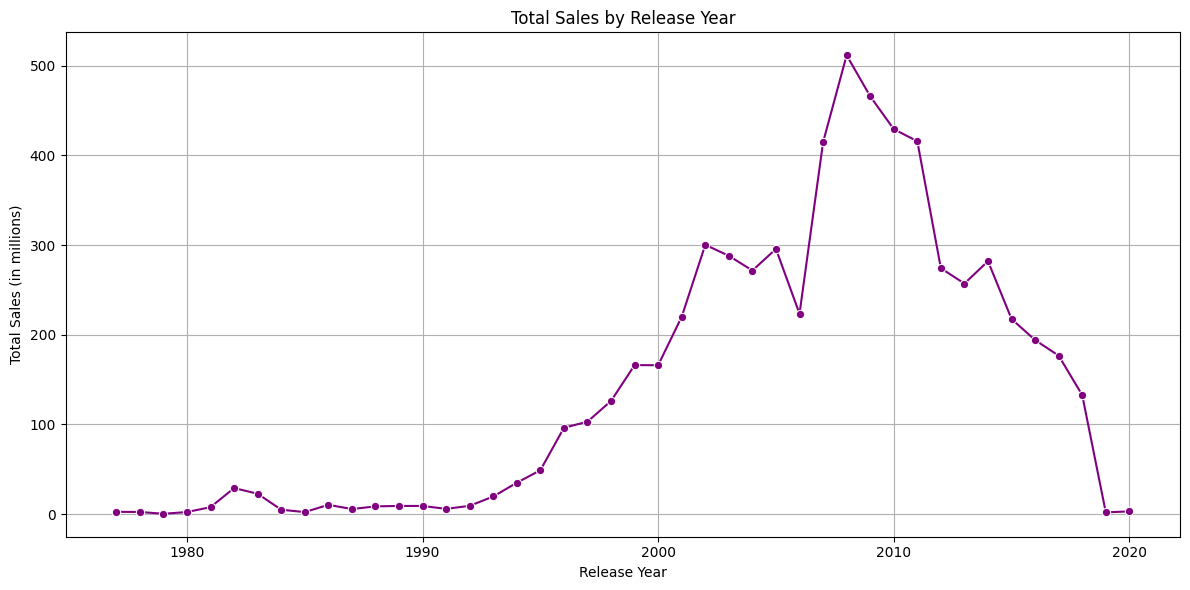

In [11]:
# ! Objective 5: To check how the release date affects game sales
df['release_date'] = pd.to_datetime(df['release_date'])

yearly_sales = df.groupby('release_year')['total_sales'].sum()
plt.figure(figsize=(12, 6))
sb.lineplot(x=yearly_sales.index, y=yearly_sales.values, marker='o', color='purple')
plt.title('Total Sales by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Total Sales (in millions)')
plt.grid(True)
plt.tight_layout()
plt.show()